一、多层感知机用于 MNIST 手写数字数据集分类（提交实现步骤描述以及下面要求提交的结果）

1、获取 MNIST 数据集，每张图片像素为28x28

把数据集下载然后保存好

In [1]:
#将图像数据从 [0, 255] 转换到 [-1, 1] 的范围，减少了大数值对模型参数的影响，让神经网络能够更快地找到收敛方向，同时减少了对模型结构和参数的干扰。
#作用是加快收敛速度和提高模型的准确性。
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 定义数据集
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

2、模型架构为包含两个隐含层的多层感知机模型
输入层维度：28	×	28	=	784
第一层隐含单元数：256 
第二层隐含单元数：256
输出层维度：10（MNIST 数据集类别数，分别为 0 到 9）

先定义多层感知机模型

In [2]:
# 定义多层感知机模型
class MLPmodel(nn.Module):
    def __init__(self):
        super(MLPmodel, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
        #改变形状
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


初始化模型，损失函数和优化器

In [3]:
model = MLPmodel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

3、画出训练和测试过程的准确率随迭代次数变化图，画出训练和测试过程的损失随迭代次数变化图。（提交最终分类精度、分类损失以及两张变化图）

Using device: cuda


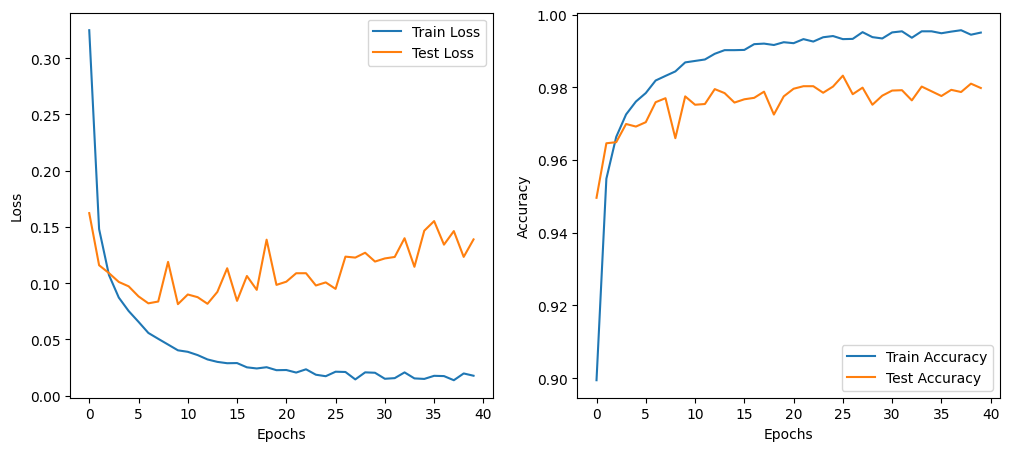

In [4]:
# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 将模型移到 GPU
model.to(device)

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
epochs = 40

for epoch in range(epochs):
    train_loss, train_correct = 0, 0
    model.train()
    
    for data, target in train_loader:
        # 将数据和标签移到 GPU
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # 计算训练损失和正确预测数
        train_loss += loss.item() * data.size(0)
        train_correct += (output.argmax(dim=1) == target).sum().item()
    
    train_losses.append(train_loss / len(train_loader.dataset))
    train_accuracies.append(train_correct / len(train_loader.dataset))

    # 测试阶段
    test_loss, test_correct = 0, 0
    model.eval()
    
    with torch.no_grad():
        for data, target in test_loader:
            # 将数据和标签移到 GPU
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            test_correct += (output.argmax(dim=1) == target).sum().item()
    
    test_losses.append(test_loss / len(test_loader.dataset))
    test_accuracies.append(test_correct / len(test_loader.dataset))

# 绘制损失和准确率曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

获取最终分类精度和分类损失

In [5]:
# 获取最终分类精度和分类损失
final_train_loss = train_losses[-1]
final_test_loss = test_losses[-1]
final_train_accuracy = train_accuracies[-1]
final_test_accuracy = test_accuracies[-1]

print(f"最终训练损失精度: {final_train_loss:.4f}")
print(f"最终测试损失精度: {final_test_loss:.4f}")
print(f"最终训练准确精度: {final_train_accuracy * 100:.2f}%")
print(f"最终测试准确精度: {final_test_accuracy * 100:.2f}%")

最终训练损失精度: 0.0176
最终测试损失精度: 0.1389
最终训练准确精度: 99.50%
最终测试准确精度: 97.98%


二、卷积神经网络用于 MNIST 手写数字数据集分类（提交实现步骤描述以及下面要求提交的结果）

1、获取 MNIST 数据集，每张图片像素为28×28

In [6]:
#将图像数据从 [0, 255] 转换到 [-1, 1] 的范围，减少了大数值对模型参数的影响，让神经网络能够更快地找到收敛方向，同时减少了对模型结构和参数的干扰。
#作用是加快收敛速度和提高模型的准确性。
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 定义数据集
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

2、模型架构：
输入层维度：28×28
（卷积层和池化层的 padding 都是用‘SAME’）
卷积层 1：卷积核大小为5×5，卷积核个数为 32（输出维度为28×28×32）
池化层 1：使用最大池化，核大小的2×2，stride 为 2（输出维度为14×14×32）
卷积层 2：卷积核大小为5×5，卷积核个数为 64（输出维度为14×14×64）
池化层 2：使用最大池化，核大小的2×2，stride为 2（输出维度为7×7×64）
（将池化层 2 的输出展平作为全连接层的输入，输入维度为7×7×64=3136）
全连接层：隐含单元数为 1024 
Dropout 层：Dropout 率为 0.25
输出层维度：10（MNIST 数据集类别数，分别为 0 到 9）

Output Size=（Input Size+2×Padding−Kernel Size）/Stride +1 

先定义模型，写一个类封装

In [16]:
import torch.nn.functional as F

# 2. 构建 CNN 模型架构
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 卷积层 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2) # 输出 28 x 28 x 32
        # 池化层 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 输出 14 x 14 x 32
        # 卷积层 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2) # 输出 14 x 14 x 64
        # 池化层 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 输出 7 x 7 x 64
        # 全连接层
        self.fc1 = nn.Linear(7 * 7 * 64, 1024)
        # Dropout 层
        self.dropout = nn.Dropout(0.25)
        # 输出层
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))       # 卷积层 1
        x = self.pool1(x)               # 池化层 1
        x = F.relu(self.conv2(x))       # 卷积层 2
        x = self.pool2(x)               # 池化层 2
        x = x.view(-1, 7 * 7 * 64)      # 展平
        x = F.relu(self.fc1(x))         # 全连接层
        x = self.dropout(x)             # Dropout
        x = self.fc2(x)                 # 输出层
        return x

# 初始化模型、损失函数和优化器
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

3、画出训练和测试过程的准确率随迭代次数变化图，画出训练和测试过程的损失随迭代次数变化图。（提交最终分类精度、分类损失以及两张变化图）

定义训练和测试函数

In [17]:
# 训练和测试函数
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
        _, predicted = output.max(1)
        correct += predicted.eq(target).sum().item()
        total += target.size(0)
    return running_loss / total, correct / total

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()
            total += target.size(0)
    return test_loss / total, correct / total


训练和测试循环

In [18]:
# 训练和测试循环
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
num_epochs = 10
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion)
    test_loss, test_acc = test(model, device, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch 1/10, Train Loss: 0.1232, Train Acc: 0.9613, Test Loss: 0.0388, Test Acc: 0.9874
Epoch 2/10, Train Loss: 0.0412, Train Acc: 0.9872, Test Loss: 0.0419, Test Acc: 0.9870
Epoch 3/10, Train Loss: 0.0300, Train Acc: 0.9907, Test Loss: 0.0280, Test Acc: 0.9904
Epoch 4/10, Train Loss: 0.0216, Train Acc: 0.9929, Test Loss: 0.0327, Test Acc: 0.9901
Epoch 5/10, Train Loss: 0.0171, Train Acc: 0.9949, Test Loss: 0.0423, Test Acc: 0.9860
Epoch 6/10, Train Loss: 0.0136, Train Acc: 0.9955, Test Loss: 0.0342, Test Acc: 0.9913
Epoch 7/10, Train Loss: 0.0135, Train Acc: 0.9956, Test Loss: 0.0236, Test Acc: 0.9930
Epoch 8/10, Train Loss: 0.0115, Train Acc: 0.9965, Test Loss: 0.0308, Test Acc: 0.9910
Epoch 9/10, Train Loss: 0.0100, Train Acc: 0.9967, Test Loss: 0.0305, Test Acc: 0.9924
Epoch 10/10, Train Loss: 0.0101, Train Acc: 0.9967, Test Loss: 0.0317, Test Acc: 0.9928


绘制变化图

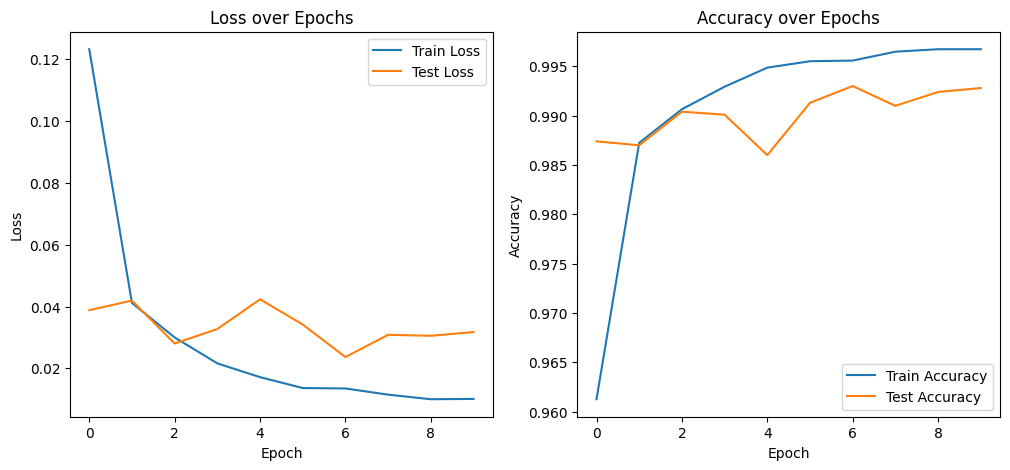

In [19]:
plt.figure(figsize=(12, 5))

# 损失变化图
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# 准确率变化图
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

获取最终损失精度和准确精度

In [20]:
# 获取最终分类精度和分类损失
finally_train_loss = train_losses[-1]
finally_test_loss = test_losses[-1]
finally_train_accuracy = train_accuracies[-1]
finally_test_accuracy = test_accuracies[-1]

print(f"最终训练损失精度: {finally_train_loss:.4f}")
print(f"最终测试损失精度: {finally_test_loss:.4f}")
print(f"最终训练准确精度: {finally_train_accuracy * 100:.2f}%")
print(f"最终测试准确精度: {finally_test_accuracy * 100:.2f}%")

最终训练损失精度: 0.0101
最终测试损失精度: 0.0317
最终训练准确精度: 99.67%
最终测试准确精度: 99.28%


三、多层感知机实现异或运算（提交实现步骤描述、源代码以及最后的测试误差） 要求：不允许使用 Tensorflow 等深度学习框架，使用 Python 实现网络的前向传播和反向传播过程。源代码文件命名为“班级_学号_姓名_BP.py”。
数据集：[[[0, 0], [0]],
[[0, 1], [1]],
[[1, 0], [1]],
[[1, 1], [0]]]

定义激活函数及其导数， 使用 Sigmoid 作为激活函数

In [21]:
import numpy as np

# 激活函数及其导数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

定义超参数，初始化权重和偏置

In [22]:
# 定义网络结构和训练参数
input_size = 2      # 输入层大小
hidden_size = 4     # 隐藏层大小
output_size = 1     # 输出层大小
learning_rate = 0.1
epochs = 5000

# 初始化权重和偏置
np.random.seed(42)
weights_input_hidden = np.random.rand(input_size, hidden_size)
weights_hidden_output = np.random.rand(hidden_size, output_size)
bias_hidden = np.random.rand(hidden_size)
bias_output = np.random.rand(output_size)

# 数据集 (XOR)
data = np.array([
    [[0, 0], [0]],
    [[0, 1], [1]],
    [[1, 0], [1]],
    [[1, 1], [0]]
])

# 提取输入和输出
X = np.array([x[0] for x in data])
y = np.array([x[1] for x in data])

/tmp/ipykernel_19427/2526734739.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([


定义前向传播过程

In [24]:
# 训练过程
for epoch in range(epochs):
    total_error = 0
    for i in range(len(X)):
        # 前向传播
        input_layer = X[i]
        hidden_layer_input = np.dot(input_layer, weights_input_hidden) + bias_hidden
        hidden_layer_output = sigmoid(hidden_layer_input)
        
        output_layer_input = np.dot(hidden_layer_output, weights_hidden_output) + bias_output
        predicted_output = sigmoid(output_layer_input)
        
        # 计算误差
        error = y[i] - predicted_output
        total_error += error**2
        
        # 反向传播
        d_predicted_output = error * sigmoid_derivative(predicted_output)
        
        error_hidden_layer = d_predicted_output.dot(weights_hidden_output.T)
        d_hidden_layer = error_hidden_layer * sigmoid_derivative(hidden_layer_output)
        
        # 更新权重和偏置
        weights_hidden_output += hidden_layer_output.reshape(-1, 1) * d_predicted_output * learning_rate
        bias_output += d_predicted_output * learning_rate
        
        weights_input_hidden += input_layer.reshape(-1, 1) * d_hidden_layer * learning_rate
        bias_hidden += d_hidden_layer * learning_rate

    # 打印每 1000 次迭代的总误差
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Error: {np.sum(total_error)}")


Epoch 100/5000, Error: 1.0134479769295983
Epoch 200/5000, Error: 1.0123001276190537
Epoch 300/5000, Error: 1.0108483596423157
Epoch 400/5000, Error: 1.0089926928210262
Epoch 500/5000, Error: 1.0065981877057015
Epoch 600/5000, Error: 1.0034971516979676
Epoch 700/5000, Error: 0.9994886836425136
Epoch 800/5000, Error: 0.994341547126673
Epoch 900/5000, Error: 0.987799183972071
Epoch 1000/5000, Error: 0.9795846038283238
Epoch 1100/5000, Error: 0.9694050349518919
Epoch 1200/5000, Error: 0.956962855100546
Epoch 1300/5000, Error: 0.9419871450322603
Epoch 1400/5000, Error: 0.9243006819620212
Epoch 1500/5000, Error: 0.9039200900847062
Epoch 1600/5000, Error: 0.8811507481853644
Epoch 1700/5000, Error: 0.8566072757209704
Epoch 1800/5000, Error: 0.8311106484383635
Epoch 1900/5000, Error: 0.8054926584081822
Epoch 2000/5000, Error: 0.7804061135101371
Epoch 2100/5000, Error: 0.756223672723759
Epoch 2200/5000, Error: 0.7330355553196756
Epoch 2300/5000, Error: 0.7107020852422484
Epoch 2400/5000, Error: 

下面对网络进行测试

In [25]:
# 测试网络
print("\n测试结果：")
for i in range(len(X)):
    input_layer = X[i]
    hidden_layer_input = np.dot(input_layer, weights_input_hidden) + bias_hidden
    hidden_layer_output = sigmoid(hidden_layer_input)
    
    output_layer_input = np.dot(hidden_layer_output, weights_hidden_output) + bias_output
    predicted_output = sigmoid(output_layer_input)
    
    print(f"Input: {X[i]} Predicted Output: {predicted_output[0]:.4f} Expected Output: {y[i][0]}")


测试结果：
Input: [0 0] Predicted Output: 0.1201 Expected Output: 0
Input: [0 1] Predicted Output: 0.8683 Expected Output: 1
Input: [1 0] Predicted Output: 0.8780 Expected Output: 1
Input: [1 1] Predicted Output: 0.1440 Expected Output: 0
